In [1]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [6]:
!pip3 install nibabel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 24.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [25]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.4.0
Numpy version: 1.26.1
Pytorch version: 2.5.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /opt/homebrew/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.10.1
Pillow version: 9.5.0
Tensorboard version: 2.14.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.20.0
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.6
pandas version: 2.0.1
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installin

In [39]:
import os
import nibabel as nib
from sklearn.model_selection import train_test_split

# Define your NIfTI image directory
image_dir = "/Users/Sepideh/Desktop/T1/IXI-T1/" 

# Load all NIfTI file paths
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.nii.gz')]
print(f"Total NIfTI files found: {len(image_paths)}")

# Split the data into training, validation, and test sets
train_val_paths, test_paths = train_test_split(image_paths, test_size=0.3, random_state=42)  # 70% for train+val, 30% for test
train_paths, val_paths = train_test_split(train_val_paths, test_size=0.2857, random_state=42)  # 20% for validation

print(f"Training size: {len(train_paths)}, Validation size: {len(val_paths)}, Test size: {len(test_paths)}")

# Example: Load one NIfTI file to verify
example_path = train_paths[100]
nifti_image = nib.load(example_path)  # Load NIfTI image
image_data = nifti_image.get_fdata()  # Access image data as a NumPy array

print(f"Loaded NIfTI image shape: {image_data.shape}")


Total NIfTI files found: 581
Training size: 290, Validation size: 116, Test size: 175
Loaded NIfTI image shape: (256, 256, 150)


In [40]:
print(f"Loaded NIfTI image type: {image_data.dtype}")
#

Loaded NIfTI image type: float64


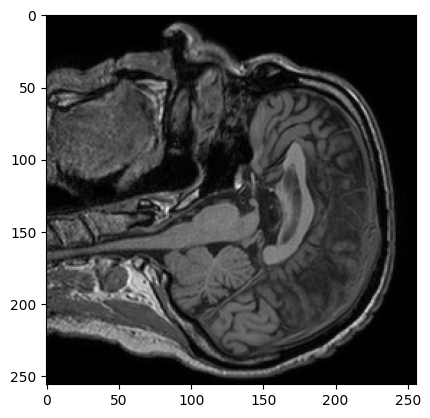

In [53]:
#this will plot full siz size 
Nifti_img =nifti_image.get_fdata()
plt.imshow(Nifti_img[:,:,Nifti_img.shape[2]//2], cmap='gray')
plt.show()

In [23]:
from monai import transforms
train_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.Lambdad(keys="image", func=lambda x: x[:, :, :, 1]),
        transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        transforms.ScaleIntensityd(keys=["image"]),
        transforms.CenterSpatialCropd(keys=["image"], roi_size=[176, 224, 155]),
        transforms.Resized(keys=["image"], spatial_size=(32, 48, 32)),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.Lambdad(keys="image", func=lambda x: x[:, :, :, 1]),
        transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        transforms.ScaleIntensityd(keys=["image"]),
        transforms.CenterSpatialCropd(keys=["image"], roi_size=[176, 224, 155]),
        transforms.Resized(keys=["image"], spatial_size=(32, 48, 32)),
    ]
)